In [2]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = (12,10)

In [5]:
X = pd.read_csv('../data/card_transactions.csv')

In [6]:
X.head()

,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


In [7]:
X.groupby('customer_id').size().value_counts()

1    8500
dtype: int64

In [8]:
X.dtypes

customer_id                          object
balance_account                     float64
purchases_amount                    float64
paid_advance                        float64
full_purchases                      float64
balance_frequency_update            float64
installments                        float64
purchases_frequency                 float64
full_purchases_frequency            float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
nr_cash_advances                      int64
nr_purchases                          int64
credit_limit                        float64
fixed_rate_period                     int64
payments                            float64
min_payments                        float64
full_payment_prc                    float64
dtype: object

In [9]:
X['purchases-balance'] = X['balance_account'] - X['purchases_amount']

<AxesSubplot:>

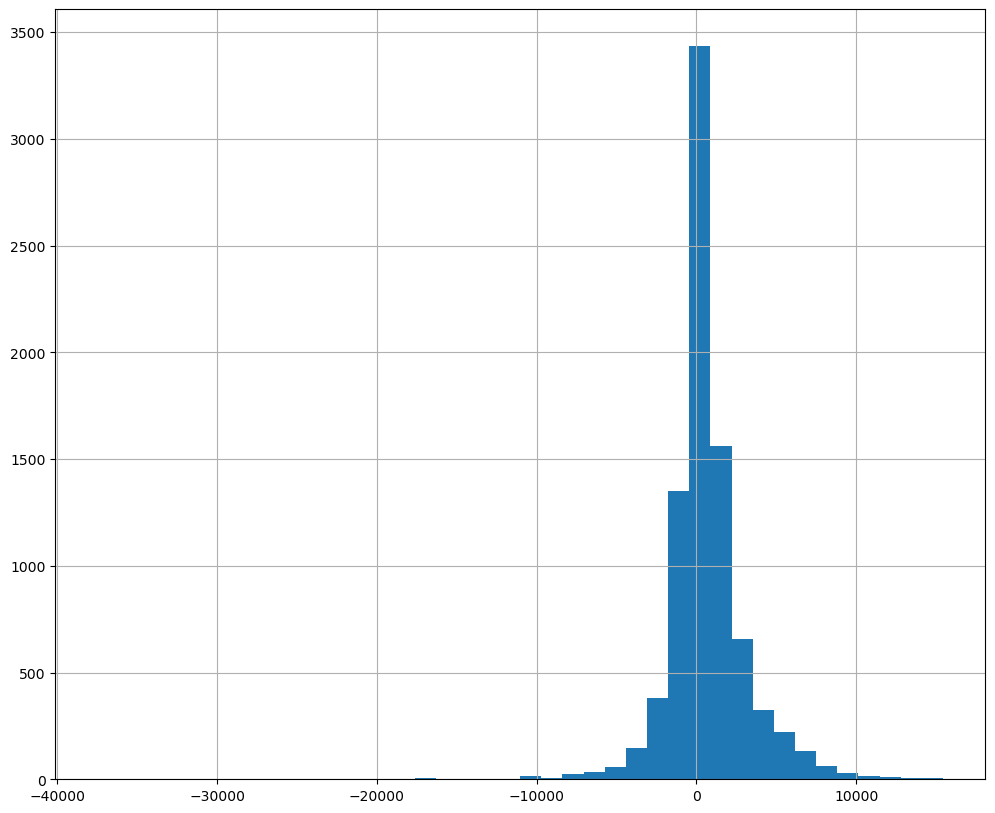

In [10]:
X['purchases-balance'].hist(bins=40)

In [25]:
corr=data.corr()

In [12]:
corr_high = corr.applymap(lambda x: round(x,2) if x > 0.8 else 0)

TypeError: '>' not supported between instances of 'str' and 'float'

In [13]:
fig, axes = plt.subplots(1,2,figsize=(30,10))
sns.heatmap(corr, annot = True, ax=axes[0])
sns.heatmap(corr_high, annot = True, ax=axes[1])